# Data Check

In [1]:
# import library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer # 결측치 대체를 위한 라이브러리
from sklearn.preprocessing import PolynomialFeatures # 교호작용 변수 생성(중요한 변수끼리의 곱)
from sklearn.preprocessing import StandardScaler 
from sklearn.feature_selection import VarianceThreshold # FeatureSelection에서 분산이 기준치보다 낮은 feature는 탈락
from sklearn.feature_selection import SelectFromModel # Feature Importance를 제공하는 모델의 importance를 활용하여 변수 선택
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

In [2]:
data_path = '/content/drive/MyDrive/Porto Seguro’s Safe Driver Prediction/'
trainset = pd.read_csv(data_path + 'train.csv')
testset = pd.read_csv(data_path + 'test.csv')

# 데이터에 대한 간략한 정보

우리는 대회에 있는 데이터 설명을 기반으로 몇 가지를 알 수 있습니다.

- 정의된 그룹은 거의 없으며 이러한 그룹에 속하는 feature에는 이름에 패턴(ind, reg, car, calc)이 포함됩니다. 
- ind는 아마도 개별적인 것을 나타내고, reg은 아마도 등록이며, car는 차량 설명이며, calc는 계산된 필드를 나타냅니다
  - 접미사 bin은 이진 feature에 사용됩니다
  - 접미사 cat는 범주형 feature에 사용됩니다
  - bin 또는 cat표시가 없는 feature는 정수(서수)의 실수(연속 값)입니다
  - 결측치는 -1로 표시됩니다
  - Target값은 feature열에 있습니다. 이것은 그 피보험자에 대한 청구 여부를 나타냅니다.
  - id는 데이터 입력 서수입니다.

In [3]:
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


- 실제로, 우리는 cat값이 범주형이고, 0에서 n사이의 정수 값이며, bin값은 이진(0 또는 1)임을 관찰할 수 있습니다.
- 데이터에 몇 개의 행과 열이 있는지 확인해 보겠습니다.

In [4]:
testset.head()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1,8,1,0,0,1,0,0,0,0,0,0,0,12,1,0,0,0.5,0.3,0.610328,7,1,-1,0,-1,1,1,1,2,1,65,1,0.316228,0.669556,0.352136,3.464102,0.1,0.8,0.6,1,1,6,3,6,2,9,1,1,1,12,0,1,1,0,0,1
1,1,4,2,5,1,0,0,0,0,1,0,0,0,0,0,5,1,0,0,0.9,0.5,0.771362,4,1,-1,0,0,11,1,1,0,1,103,1,0.316228,0.606320,0.358329,2.828427,0.4,0.5,0.4,3,3,8,4,10,2,7,2,0,3,10,0,0,1,1,0,1
2,2,5,1,3,0,0,0,0,0,1,0,0,0,0,0,10,0,0,0,0.4,0.0,0.916174,11,1,-1,0,-1,14,1,1,2,1,29,3,0.400000,0.896239,0.398497,3.316625,0.6,0.6,0.6,2,3,7,4,6,3,12,4,0,2,4,0,0,0,0,0,0
3,3,0,1,6,0,0,1,0,0,0,0,0,0,0,0,4,1,0,0,0.1,0.2,-1.000000,7,1,-1,0,-1,1,1,1,2,1,40,2,0.374166,0.652110,0.381445,2.449490,0.1,0.5,0.5,2,1,7,3,12,1,13,5,1,0,5,1,0,1,0,0,0
4,4,5,1,7,0,0,0,0,0,1,0,0,0,0,0,4,1,0,0,0.9,0.4,0.817771,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.812914,0.385097,3.316625,0.9,0.6,0.8,3,4,7,1,10,4,12,4,0,0,4,0,1,1,0,0,1


In [5]:
# 데이터의 행과 열을 확인해본다.
# 타겟과 id를 제외한 58개의 feature가 존재한다.
# 특이한 점은 train set이 test set보다 적다.

print(trainset.shape)
print(testset.shape)

(595212, 59)
(892816, 58)


- train 데이터셋에는 59개의 열이 있으며 test 데이터셋에는 58개만 있습니다. 
- 이 데이터셋에서 target을 추출했어야 하므로, 이것은 괜찮아 보입니다.
- 모든 것이 정상인지 확인하기 위해 두 데이터셋에 설정된 열의 차이를 확인하겠습니다.

In [6]:
print('Columns in train and not in test dataset:',set(trainset.columns)-set(testset.columns))

Columns in train and not in test dataset: {'target'}


In [7]:
print(trainset.columns)

Index(['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],


# Metadata
- 데이터 조작을 쉽게하기위해, 우리는 몇 가지 메타 정보를 trainset의 변수와 연관시킬 것입니다.
- 이를 통해 분석, 검사 또는 모델링을 위한 다양한 feature를 쉽게 선택할 수 있습니다.
- 우리는 car,ind,reg 및 calc 유형의 특징에 대한 categorical field도 사용하고 있습니다.

- 메타 데이터로 사용할 것들:
  -  use: input, ID, target
  - type: nominal, interval(real), ordinal(integer), binary
  - preserve: True or False 
  - data type: int, float, str
  - category: ind, reg, car, calc

In [8]:
# append를 위해 빈 리스트를 만들어주었음
data = []

for feature in trainset.columns:
  # 데이터의 역할을 지정(독립변수, 종속변수, id(PM))
  if feature == 'target':
    use = 'target'
  elif feature == 'id':
    use = 'id'
  else:
    use = 'input'

  # 데이터의 레벨을 지정(명목 변수, 간격 변수, 순서 변수등을 레벨이라고 표현한 듯)
  if 'bin' in feature or feature == 'target':
    type = 'binary'
  elif 'cat' in feature or feature == 'id':
    type = 'categorical'
  elif trainset[feature].dtype == float or isinstance(trainset[feature].dtype, float):
    type = 'real'
  elif trainset[feature].dtype == int :
    type = 'integer'

  # id는 False는 지정해주어 버리기로 하고, 나머지는 True로 가져감
  preserve = True
  if feature == 'id':
    preserve = False

  # 데이터의 타입 지정
  dtype = trainset[feature].dtype

  category = 'none'
  # category 정의
  if 'ind' in feature:
    category = 'individual'
  elif 'reg' in feature:
    category = 'registration'
  elif 'car' in feature:
    category = 'car'
  elif 'calc' in feature:
    category = 'calculated'

  # DataFrame으로 만들기 위해 리스트에 append하기 전에 딕셔너리 타입으로 만들어주었음
  feature_dictionary = {
      'varname': feature,
      'use': use,
      'type': type,
      'preserve': preserve,
      'dtype': dtype,
      'category': category
      }
  data.append(feature_dictionary)

metadata = pd.DataFrame(data, columns = ['varname', 'use','type','preserve', 'dtype', 'category'])
metadata.set_index('varname', inplace=True)
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,integer,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,integer,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


우리는 categorical 값들으 추출할 수 있다.

In [9]:
metadata[(metadata.type == 'categorical')&(metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

모든 feature를 검사하여 category 고유값이 몇 개있는지 확인해 보겠습니다.

In [10]:
pd.DataFrame({'count': metadata.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registration,3


- 20개의 계산된 feature, 16개의 자동차 18개의 개인 그리고 3개의 등록 feature를 가지고 있습니다.
- 이제 모든 기능을 검사하여 사용 및 feature 고유값이 얼마나 되는지 확인해 보겠습니다.

In [11]:
pd.DataFrame({'count': metadata.groupby(['use','type'])['use'].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,integer,16
4,input,real,10
5,target,binary,1


- 명목 feature(Id) 1개, binary 값 20개, 실수 21개, 범주 feature 16개가 있다.
- 이 모든 것은 입력 값과 이진수인 Target값이다.

# Data analysis and statistic

## Target variable

<Figure size 432x288 with 0 Axes>

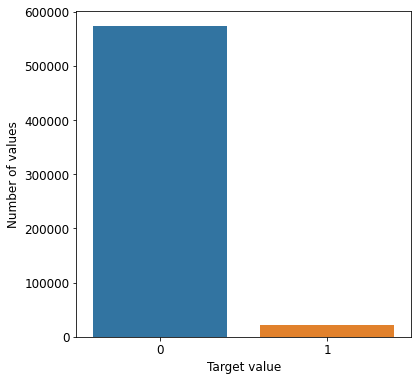

In [12]:
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
x = trainset['target'].value_counts().index.values
y = trainset['target'].value_counts().values

# Bar plot
# Target 평균 내림차순으로 정렬
sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Target value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

- Target 데이터의 3.64%만이 1개의 값을 가지고 있습니다.
- 이는 train 데이터셋이 매우 불균형하다는 것을 의미합니다.
- Target=0으로 레코드를 UnderSampling하거나 Target=1을 OverSampling할 수 있습니다.
- 대규모 데이터셋이기 때문에 Target=0으로 레코드를 UnderSampling합니다.

## Real features

In [13]:
variable = metadata[(metadata.type == 'real') & (metadata.preserve)].index
trainset[variable].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [14]:
(pow(trainset['ps_car_12']*10,2)).head(10)

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

In [15]:
(pow(trainset['ps_car_15'],2)).head(10)

0    13.0
1     6.0
2    11.0
3     4.0
4     4.0
5     9.0
6    10.0
7    11.0
8     8.0
9    13.0
Name: ps_car_15, dtype: float64

**결측치가 있는 Feature**

ps_reg_03, ps_car_12, ps_car_14에 결측치가 있음(최솟값이 -1)

**등록 Feature**

ps_reg_01과 ps_reg_02는 분모가 10인 분수입니다(값은 0.1, 0.2, 0.3)

**자동차 Feature**

ps_car_12는 자연수의 제곱근이며, ps_car_15는 자연수의 제곱근이다. Pairplot을 사용하여 값을 나타냅니다.

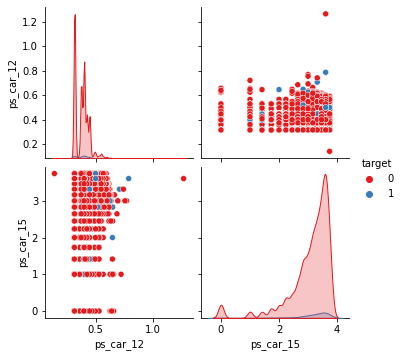

In [16]:
sample = trainset.sample(frac=0.05, random_state=2023)
var = ['ps_car_12', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde')
plt.show()

**Calculated Features**

- ps_calc_01, ps_calc_02 및 ps_calc_03 feature은 분포가 매우 유사하며 최댓값이 세 개 모두 0.9이므로 일종의 비율이라고 볼 수 있습니다.
- 다른 계산된 값은 최댓값이 정수 값(5,6,7,10,12)입니다.

밀도 plot을 사용하여 실제 형상 분포를 시각화해 보겠습니다.

<Figure size 432x288 with 0 Axes>

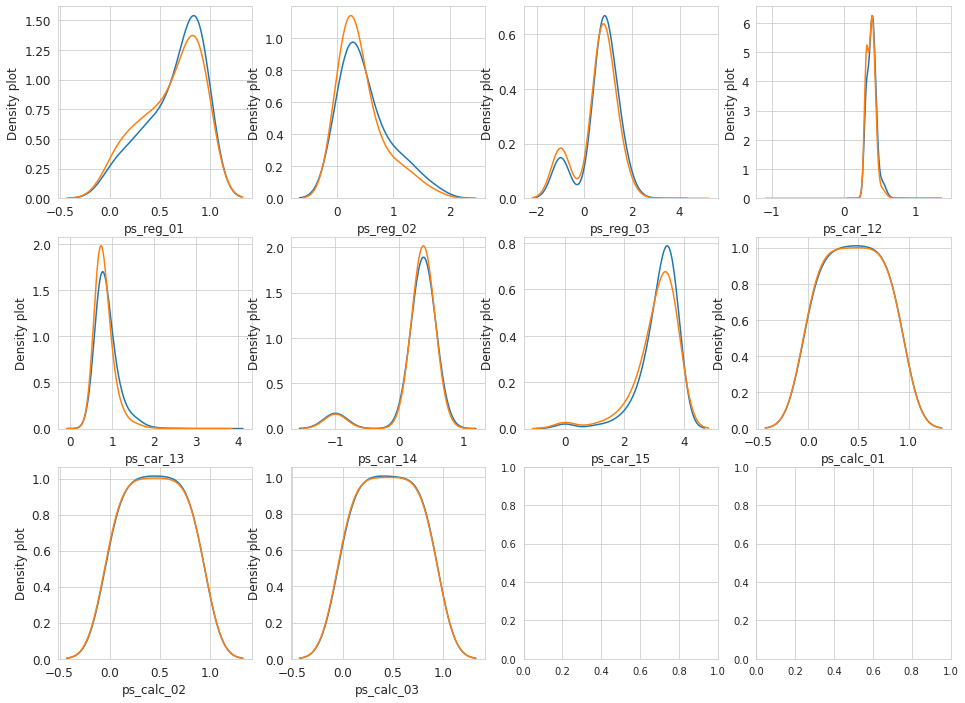

In [17]:
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target']!=0]
t0 = trainset.loc[trainset['target']==0]

sns.set_style('whitegrid')
plt.figure()
fig , ax = plt.subplots(3, 4, figsize = (16,12))

for feature in var:
  i += 1
  plt.subplot(3,4,i)
  sns.kdeplot(t1[feature], bw=0.5, label='target = 1')
  sns.kdeplot(t0[feature], bw=0.5, label='target = 0')
  plt.ylabel('Density plot', fontsize=12)
  plt.xlabel(feature, fontsize=12)
  locs, labels = plt.xticks()
  plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

ps_reg_02, ps_car_13, ps_car_15는 `target=0`과 `target=1`과 관련된 값 집합 간에 가장 다른 분포를 보여줍니다.

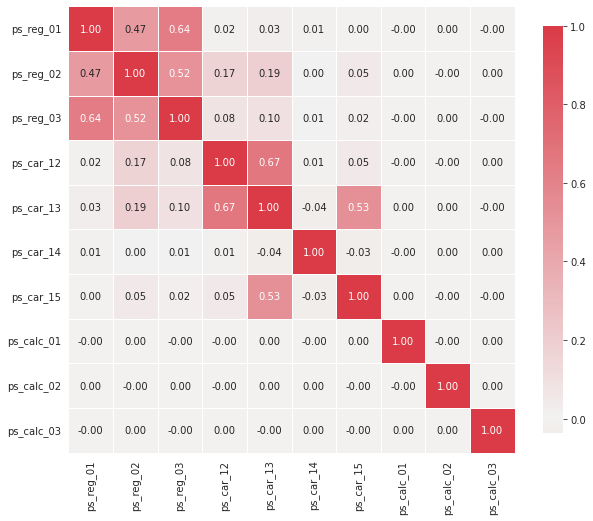

In [18]:
def corr_heatmap(var):
  correlations = trainset[var].corr()

  # 두 색상 사이의 heatmap 만들기
  cmap = sns.diverging_palette(50, 10 , as_cmap=True)

  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
              square=True, linewidths=.5, annot=True, cbar_kws={'shrink':.75})
  plt.show();

var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
corr_heatmap(var)

- 상관 관계가 강한 변수의 그림을 시각화해 보겠습니다. 다음과 같습니다:

  - ps_reg_01과 ps_reg_02(0.47)
  - ps_reg_01과 ps_reg_03(0.64)
  - ps_reg_02와 ps_reg_03(0.52)
  - ps_car_12와 ps_car_13(0.67)
  - ps_car_13과 ps_car_15(0.53)

- 상관 관계가 있는 값의 쌍을 표시하기 위해 pairplot을 사용합니다.
- 쌍을 표현하기 전에 샘플에서 2%만 사용하여 데이터를 하위 샘플링합니다.

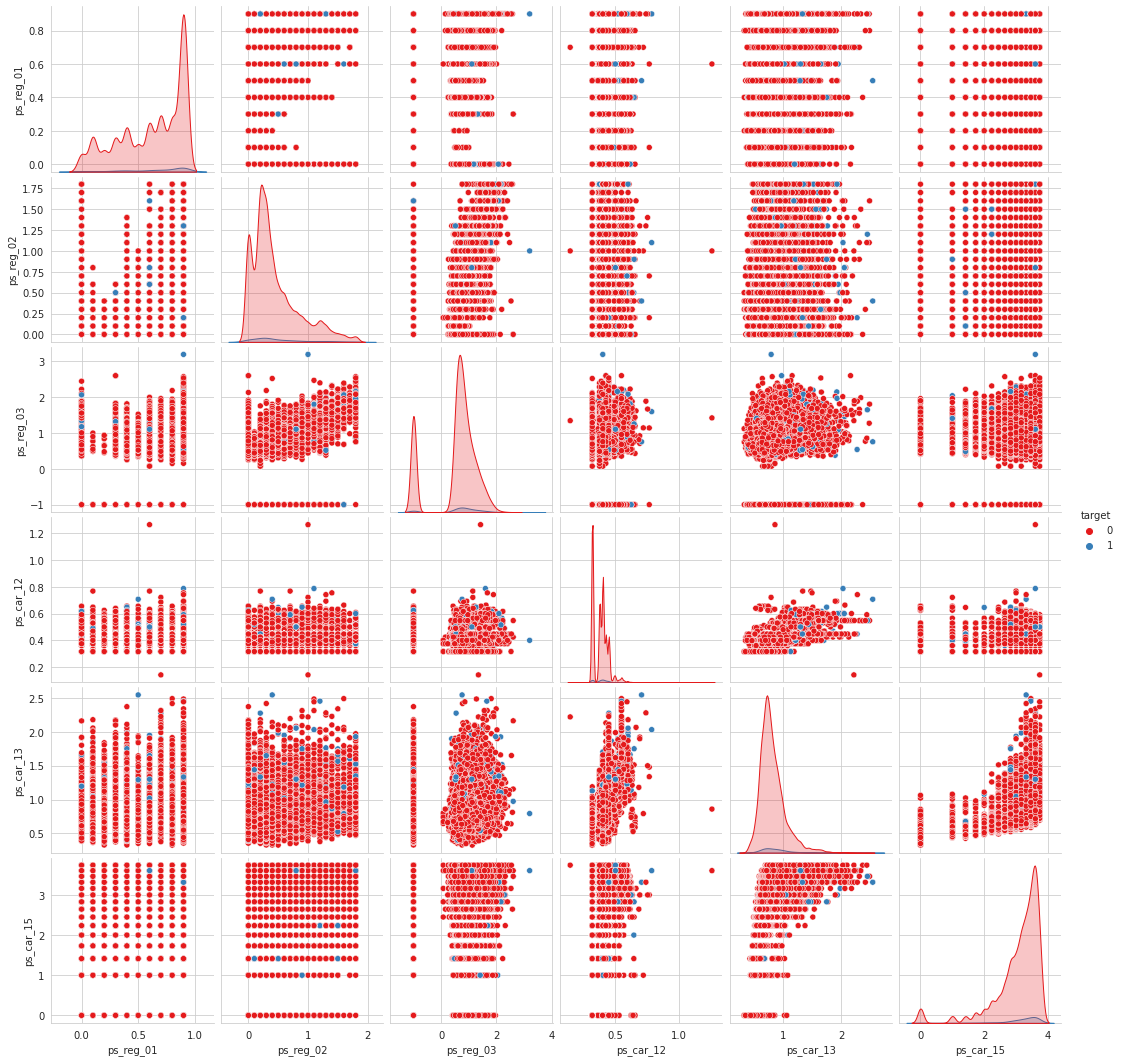

In [19]:
sample = trainset.sample(frac=0.05, random_state=2023)
var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'target']
sample =sample[var]
sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde')
plt.show();

## Binary Features

In [20]:
v = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
trainset[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- train 데이터셋에서 이진 데이터의 분포를 plot해봅시다. 
- 파란색은 0의 백분율을 나타내고 빨간색은 1의 백분율을 나타냅니다.

<Figure size 432x288 with 0 Axes>

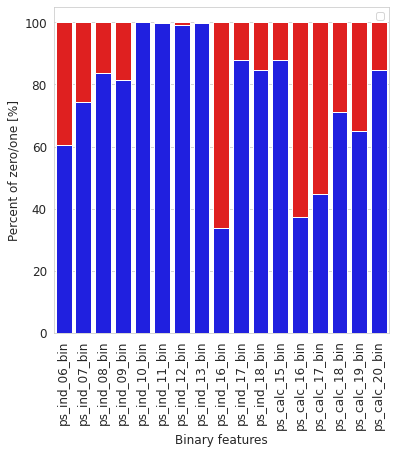

In [21]:
bin_col = [col for col in trainset.columns if '_bin'  in col]
zero_list = []
one_list = []

for col in bin_col:
  zero_list.append((trainset[col]==0).sum()/trainset.shape[0]*100)
  one_list.append((trainset[col]==1).sum()/trainset.shape[0]*100)

plt.figure()
fig, ax = plt.subplots(figsize=(6,6))

# Bar plot
p1 = sns.barplot(ax=ax, x=bin_col, y=zero_list, color='blue')
p2 = sns.barplot(ax=ax, x=bin_col, y=one_list, bottom= zero_list, color='red')
plt.ylabel('Percent of zero/one [%]', fontsize=12)
plt.xlabel('Binary features', fontsize=12)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend((p1,p2), ('Zero', 'One'))
plt.show();

- ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin 및 ps_ind_13_bin은 값 1의 수가 매우 적습니다.
- 반면 ps_ind_16_bin 및 ps_cals_16_bin은 값 1의 수가 매우 큽니다(60% 이상).

이제 이항 데이터의 분포와 대상 변수의 해당 값을 살펴보겠습니다.

<Figure size 432x288 with 0 Axes>

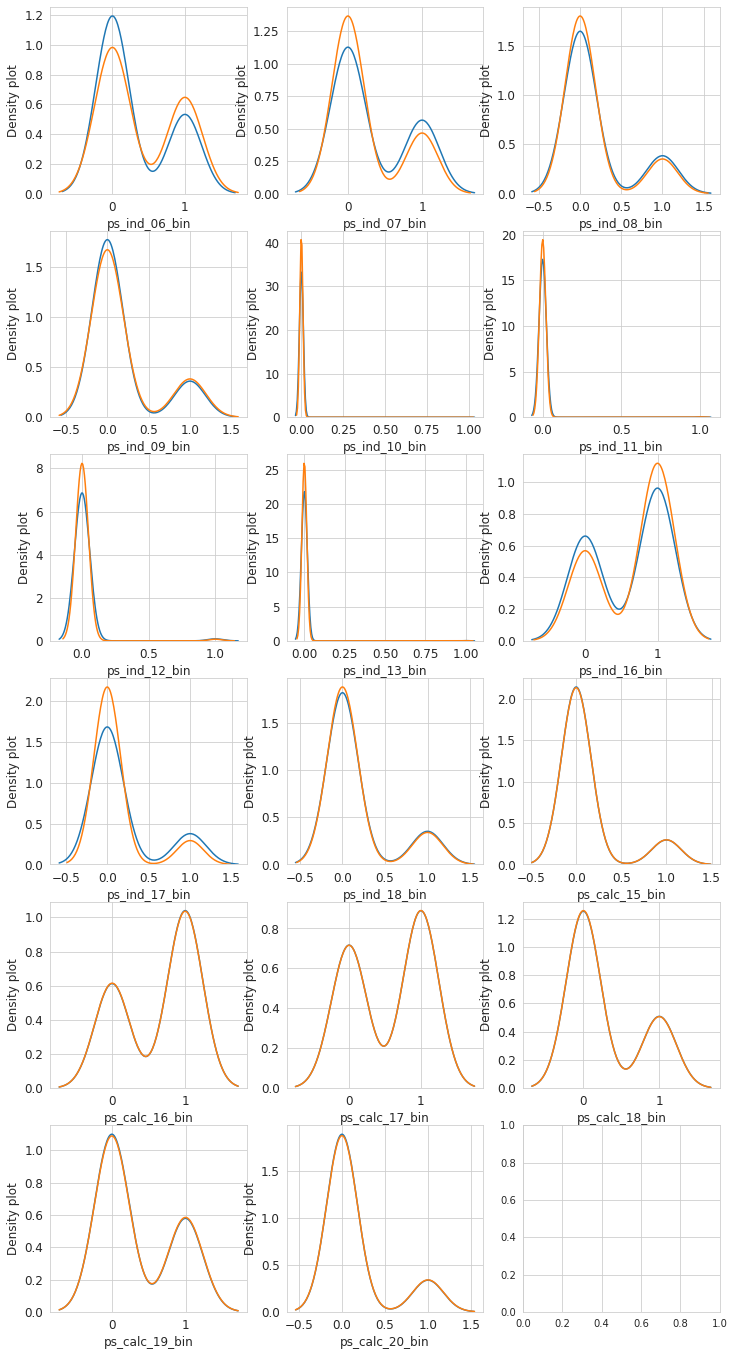

In [22]:
var = metadata[(metadata.type=='binary')&(metadata.preserve)].index
var = [col for col in trainset.columns if '_bin' in col]
i = 0
t1 = trainset.loc[trainset['target']!=0]
t0 = trainset.loc[trainset['target']==0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(6,3, figsize=(12,24))

for feature in var:
  i +=1
  plt.subplot(6,3,i)
  sns.kdeplot(t1[feature], bw=0.5, label='target=1')
  sns.kdeplot(t0[feature], bw=0.5, label='target=0')
  plt.ylabel('Density plot', fontsize=12)
  plt.xlabel(feature, fontsize=12)
  locs, labels = plt.xticks()
  plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

- ps_ind_06_bin, ps_ind_07_bin, ps_ind_16_bin, ps_ind_17_bin은 Target이 동일한 값에 대해 1과 0의 분포 사이에서 높은 균형을 나타냅니다.
- ps_ind_08_bin은 다른 특징들이 잘 균형을 이루며 비슷한 밀도 그림을 가지고 있다.

## Categorical Features

- 우리는 두 가지 방법으로 범주형 데이터에 대한 분포를 나타낼 것이다. 
- 먼저 범주 값당 Target=1의 백분율을 계산하고 막대 그래프를 사용하여 이러한 백분율을 나타냅니다.

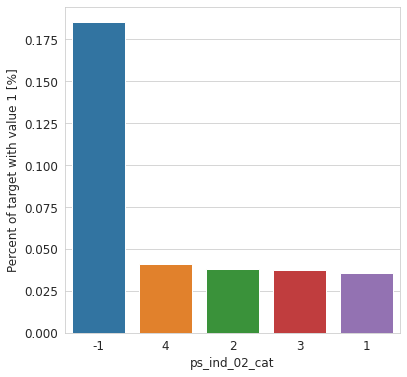

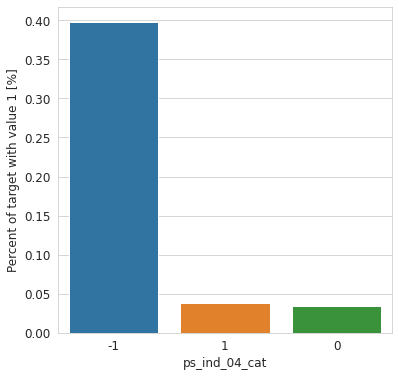

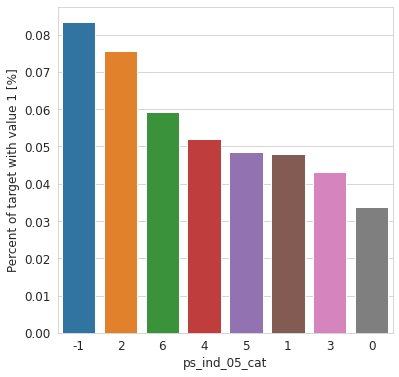

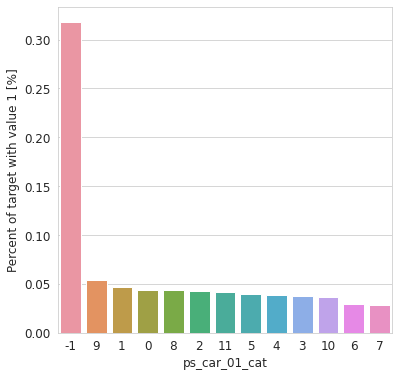

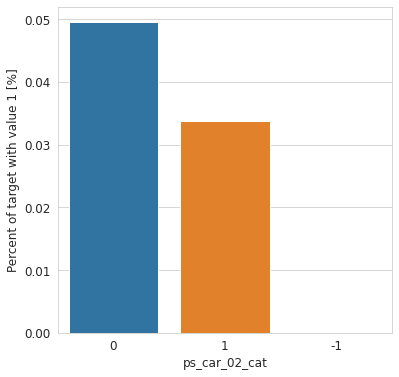

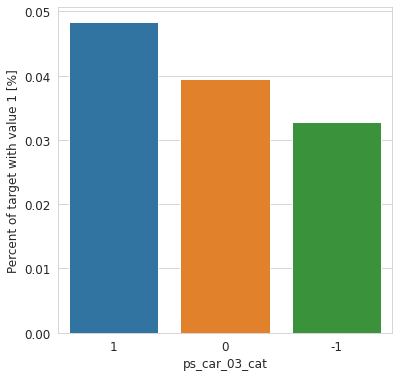

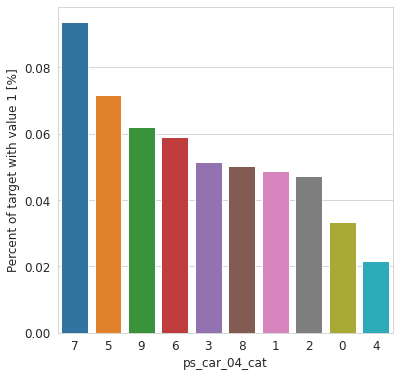

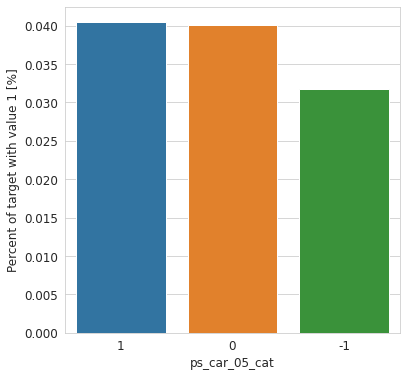

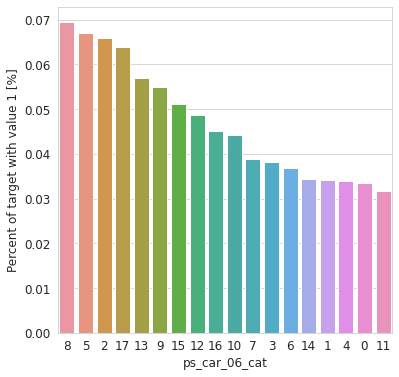

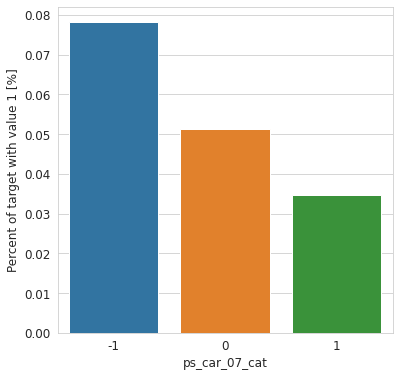

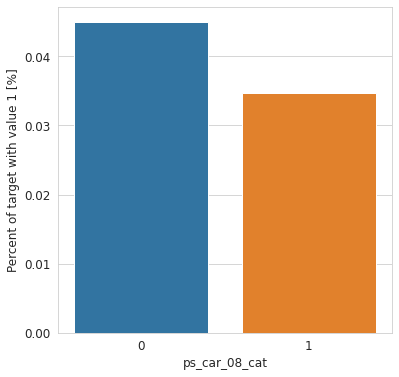

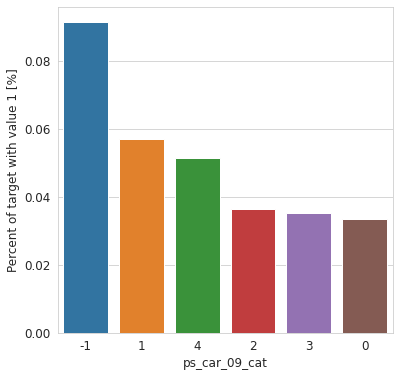

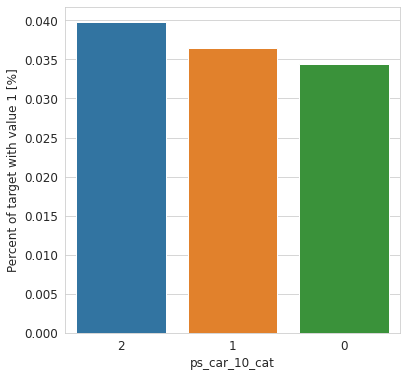

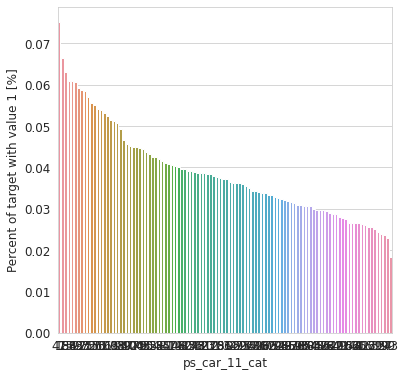

In [23]:
var = metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

for feature in var:
  fig, ax = plt.subplots(figsize=(6,6))
  
  # 범주 값당 Target = 1의 백분율 계산
  cat_perc = trainset[[feature, 'target']].groupby([feature], as_index=False).mean()
  cat_perc.sort_values(by='target', ascending=False, inplace=True)
  # Bar plot
  # target 평균 내림차순 정렬
  sns.barplot(ax=ax, x=feature, y='target', data=cat_perc, order=cat_perc[feature])
  plt.ylabel('Percent of target with value 1 [%]', fontsize=12)
  plt.xlabel(feature, fontsize=12)
  plt.tick_params(axis='both', which='major', labelsize=12)
  plt.show();

- 또는 밀도 그림을 사용하여 범주형 특징을 나타냅니다. 
- 우리는 target=0과 target=1로 값을 선택하고 동일한 그래픽에 두 밀도 그림을 나타낸다.

<Figure size 432x288 with 0 Axes>

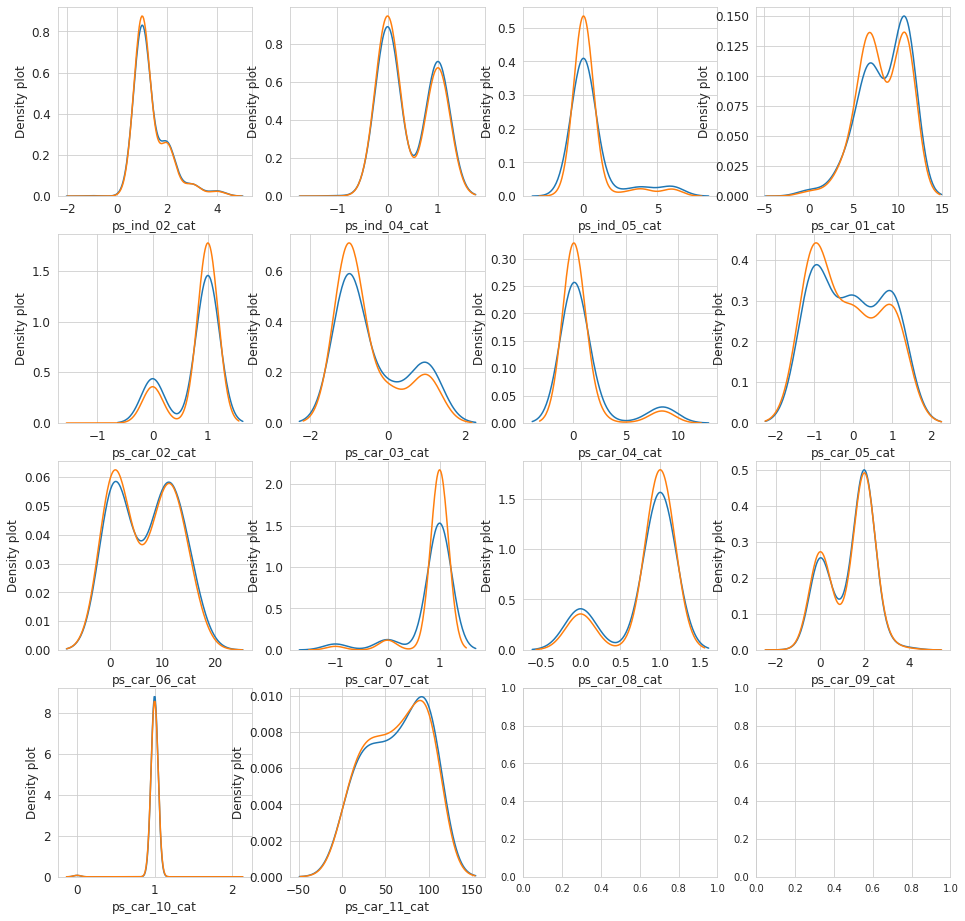

In [24]:
var = metadata[(metadata.type == 'categorical') & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target']!=0]
t0 = trainset.loc[trainset['target']==0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(4,4, figsize=(16,16))

for feature in var:
  i +=1
  plt.subplot(4,4,i)
  sns.kdeplot(t1[feature], bw=0.5, label='target = 1')
  sns.kdeplot(t0[feature], bw=0.5, label='target = 0')
  plt.ylabel('Density plot', fontsize=12)
  plt.xlabel(feature, fontsize=12)
  locs, labels = plt.xticks()
  plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

ps_car_03_cat, ps_car_05_cat는 target=0과 target=1과 관련된 값 사이에서 가장 다른 밀도 그림을 보여줍니다.

# Data unbalance between train and test data

train 및 test 데이터셋의 feature 분포를 비교해 보겠습니다.

먼저 등록 feature부터 살펴보겠습니다.

<Figure size 432x288 with 0 Axes>

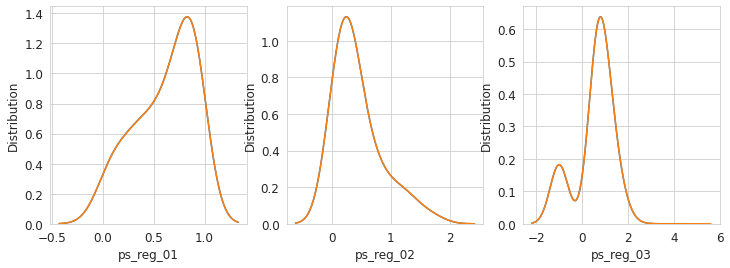

In [25]:
var = metadata[(metadata.category == 'registration') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(1,3, figsize=(12,4))
i = 0
for feature in var:
  i = i+1
  plt.subplot(1,3,i)
  sns.kdeplot(trainset[feature], bw=0.5, label='train')
  sns.kdeplot(testset[feature], bw=0.5, label='test')
  plt.ylabel('Distribution', fontsize=12)
  plt.xlabel(feature, fontsize=12)
  locs, labels = plt.xticks()
  plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

모든 reg feature는 균형 잡힌 train 및 test 데이터셋을 보여줍니다.

계속해서 자동차 feature를 살펴보겠습니다.

<Figure size 432x288 with 0 Axes>

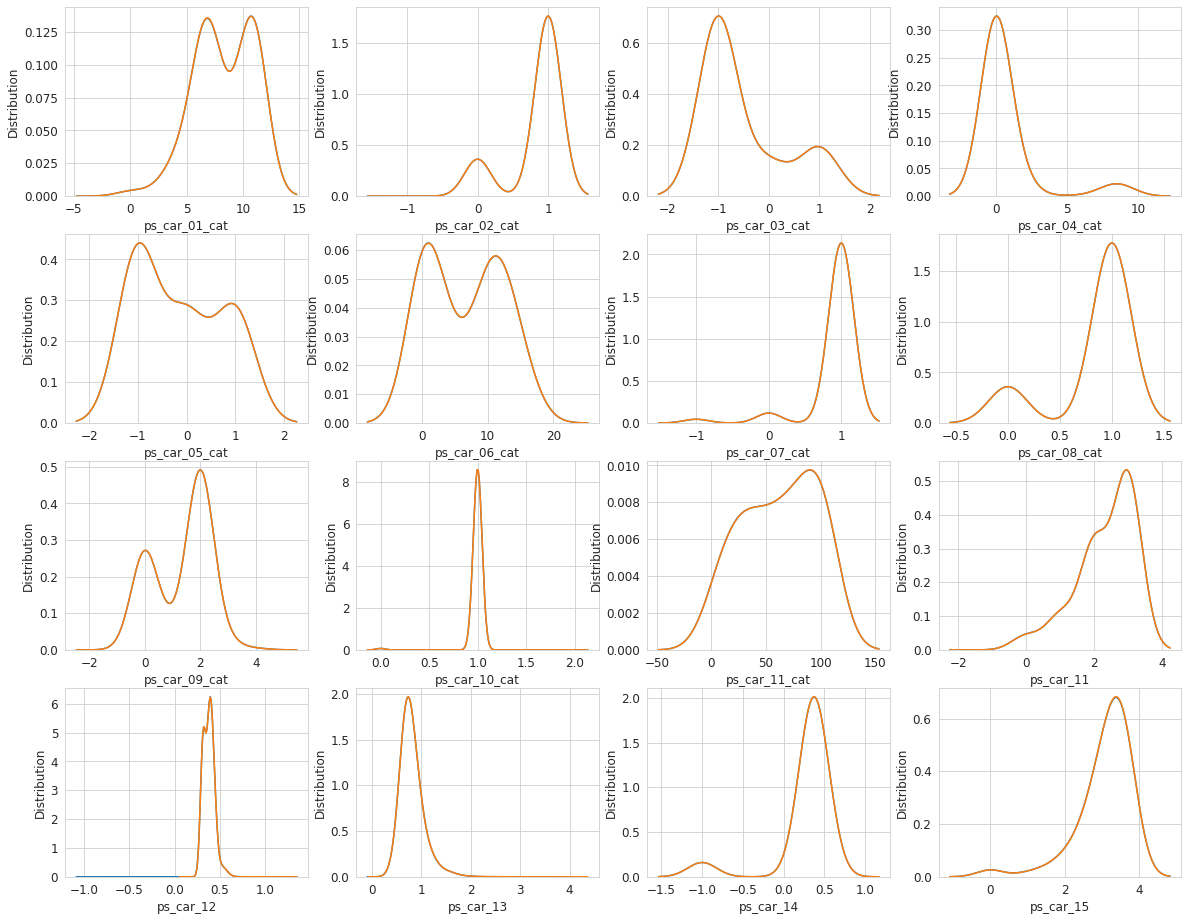

In [26]:
var = metadata[(metadata.category=='car')&(metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(4,4, figsize=(20,16))
i = 0
for feature in var:
  i = i+1
  plt.subplot(4,4,i)
  sns.kdeplot(trainset[feature], bw=0.5, label='train')
  sns.kdeplot(testset[feature], bw=0.5, label='test')
  plt.ylabel('Distribution', fontsize=12)
  plt.xlabel(feature, fontsize=12)
  locs, labels = plt.xticks()
  plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

차량 feature를 보면 모든 변수가 train과 테스트 데이터셋 간에 균형이 잘 잡혀 있습니다.

이제 Ind(개별) 값을 살펴보겠습니다.

<Figure size 432x288 with 0 Axes>

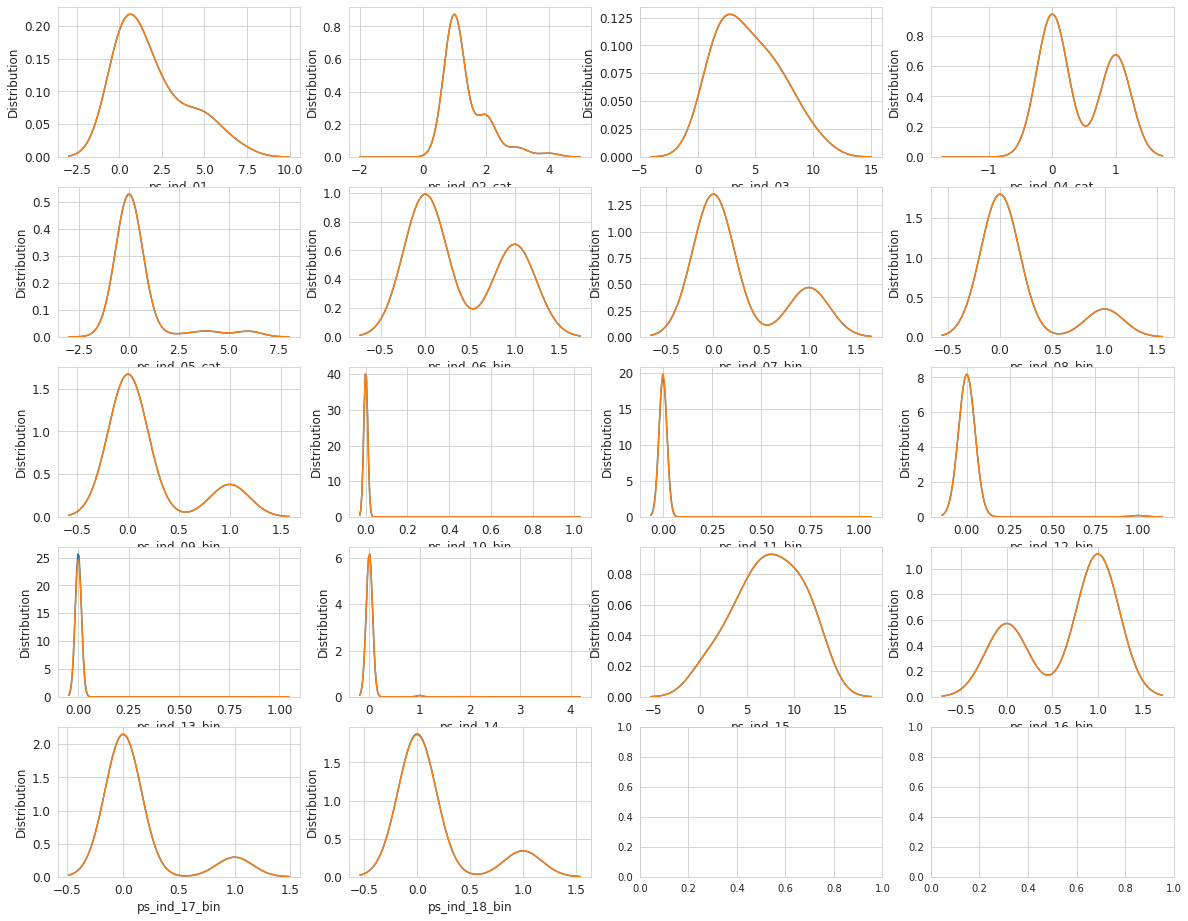

In [27]:
var = metadata[(metadata.category=='individual')&(metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(5,4, figsize=(20,16))
i = 0
for feature in var:
  i = i+1
  plt.subplot(5,4,i)
  sns.kdeplot(trainset[feature], bw=0.5, label='train')
  sns.kdeplot(testset[feature], bw=0.5, label='test')
  plt.ylabel('Distribution', fontsize=12)
  plt.xlabel(feature, fontsize=12)
  locs, labels = plt.xticks()
  plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

모든 인덱스 feature는 train 및 테스트 데이터셋 간에 균형이 잘 잡혀 있습니다.

이제 계산 feature를 확인해 보겠습니다.

<Figure size 432x288 with 0 Axes>

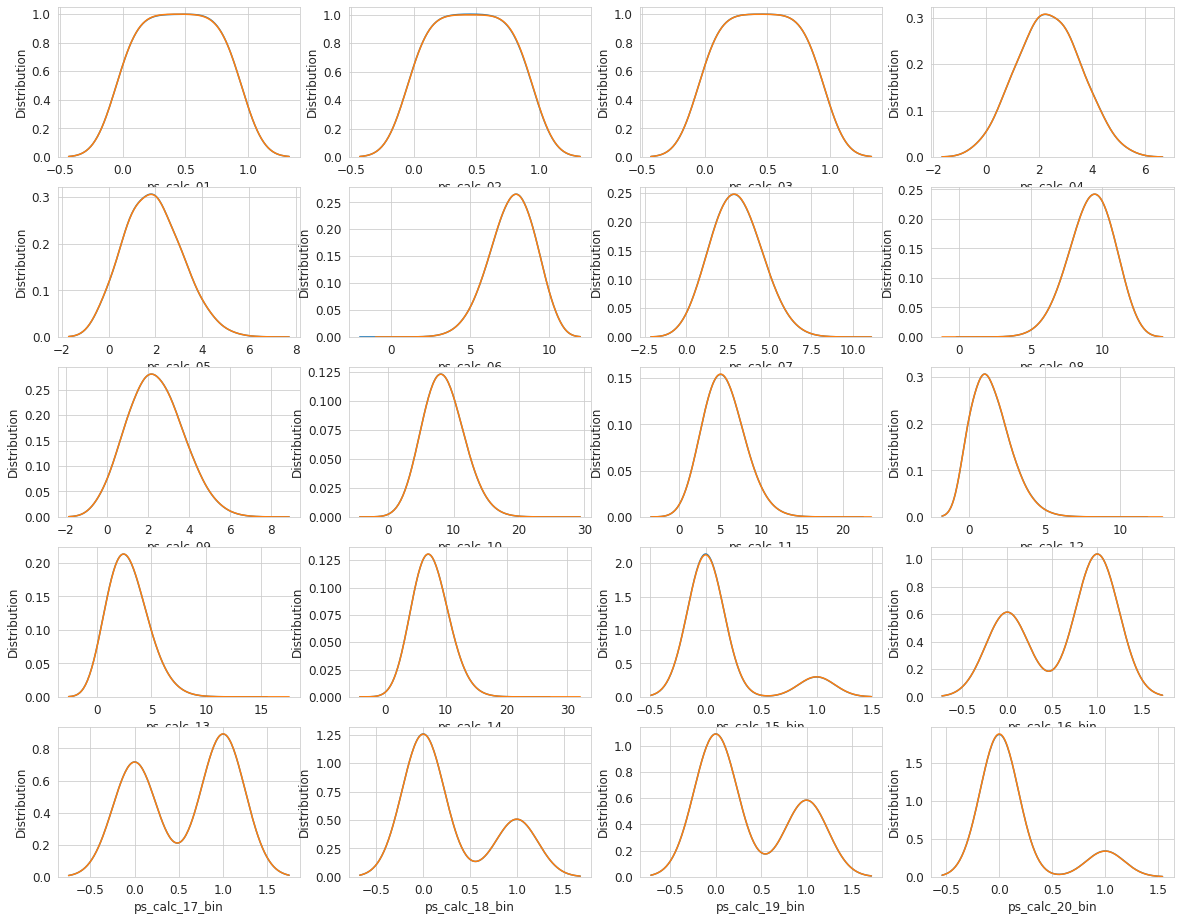

In [28]:
var = metadata[(metadata.category == 'calculated') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(5,4,figsize=(20,16))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(5,4,i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

모든 계산 기능은 train과 test 세트 간에 균형이 잘 잡혀 있습니다.

- train과 test 세트 사이의 균형도 확인할 수 있습니다. 
- 또한 계산 기능은 모두 엔지니어링된 것일 수 있으며 실제로는 관련이 없을 수도 있습니다. 
- 이는 하나 이상의 예측 모델을 사용하여 CV 점수를 사용하여 신중하게 연속적으로 제거함으로써만 평가할 수 있다.

# Check data quality

결측치가 있는 feature를 검사해봅시다.

In [29]:
vars_with_missing = []
for feature in trainset.columns:
  missings = trainset[trainset[feature]== -1][feature].count()
  if missings > 0:
    vars_with_missing.append(feature)
    missings_perc = missings/trainset.shape[0]

    print('Variable {} has {} records ({:.2f}) with missing values'.format(feature, missings, missings_perc))

print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 216 records (0.00) with missing values
Variable ps_ind_04_cat has 83 records (0.00) with missing values
Variable ps_ind_05_cat has 5809 records (0.01) with missing values
Variable ps_reg_03 has 107772 records (0.18) with missing values
Variable ps_car_01_cat has 107 records (0.00) with missing values
Variable ps_car_02_cat has 5 records (0.00) with missing values
Variable ps_car_03_cat has 411231 records (0.69) with missing values
Variable ps_car_05_cat has 266551 records (0.45) with missing values
Variable ps_car_07_cat has 11489 records (0.02) with missing values
Variable ps_car_09_cat has 569 records (0.00) with missing values
Variable ps_car_11 has 5 records (0.00) with missing values
Variable ps_car_12 has 1 records (0.00) with missing values
Variable ps_car_14 has 42620 records (0.07) with missing values
In total, there are 13 variables with missing values


# Prepare the data for model

## Drop **calc** Columns

- 참고문헌 [5]에서 권장하는 대로 계산 열도 삭제합니다. 
- 이것들은 모두 공학적인 것으로 보이며, 드미트리 알투호프에 따르면, 그는 CV 점수를 향상시키는 동시에 성공적으로 모두 제거할 수 있었다.

In [30]:
col_to_drop = trainset.columns[trainset.columns.str.startswith('ps_calc_')]
trainset = trainset.drop(col_to_drop, axis=1)
testset = testset.drop(col_to_drop, axis=1)

## Drop variables with too many missing values

누락된 값이 2인 변수 ps_car_03_cat와 ps_car_05_cat 중에서 드롭할 변수를 선택합니다.

In [31]:
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
trainset.drop(vars_to_drop, inplace=True, axis=1)
testset.drop(vars_to_drop, inplace=True, axis=1)
metadata.loc[(vars_to_drop), 'preserve'] = False # meta update

In [32]:
# Noise를 일으키는 함수
def add_noise(series, noise_level): #시리즈 값과 노이즈 레벨을 변수로 받아서
  return series * (1+noise_level *np.random.randint(len(series))) # 시리즈(1+노이즈레벨 * 표준평균분포로부터 샘플링된 난수)로 return


def target_encode(trn_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
  '''
  Smoothing은 다니엘 미키-바레카에 의해 다음 논문과 같이 계산됩니다.
  https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
  trn_series : 범주형 feature을 pd로 훈련합니다(Series).
  tst_series : 범주형 feature를 pd로 테스트합니다(Series).
  target : 대상 데이터를 pd로 지정합니다(Series).
  min_color_leaf(int) : 범주 평균을 고려할 최소 샘플
  smoothing(int): 범주형 평균과 이전 평균의 균형을 조정하는 smoothing 효과
  '''
  # trn_series는 train['ps_car_11_cat'], target은 train['target'] / 두 시리즈의 길이가 같은지 확인
  assert len(trn_series) == len(target) 
 
  # train['ps_car_11_cat']과 test['ps_car_11_cat']의 이름이 같은지도 확인
  assert trn_series.name == tst_series.name 
  
  # 두 시리즈를 열을 기준으로 concat한 뒤, temp라는 이름의 변수로 저장 
  temp = pd.concat([trn_series, target], axis=1)

  # target 열의 값들을 train['ps_car_11_cat']기준으로 그룹화한 뒤 mean한수와 count함수를 적용한 값을 averages 변수에 저장
  # averages 함수는 각 Value별 target 평균과 횟수 정보를 담고 있습니다.
  averages = temp.groupby(by=trn_series.name)[target.name].agg(['mean', 'count'])

  # smoothing 계산
  smoothing = 1/ (1+np.exp(-(averages['count'] - min_samples_leaf) / smoothing))

  # prior값은 train['target']의 평균값 / undersampling을 통해 0과 1의 비율을 9:1로 맞추었기 때문에 prior값은 0.1
  prior = target.mean()
  
  # average에 target이라는 이름을 가진 열을 추가 값은 Smoothing을 활용하여 변환
  averages[target.name] = prior * (1-smoothing) + averages['mean'] * smoothing
  
  # 필요한 값은 Smoothing한 값 뿐이라서 drop을 활용하여 mean과 count를 drop한다
  averages.drop(['mean', 'count'], axis=1, inplace=True)
  # trn series 평균 적용
  ft_trn_series = pd.merge(trn_series.to_frame(trn_series.name), # ps_car_11_cat 시리즈를 to_frame으로 데이터프레임으로 가져옴
                           averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}), # averages의 인덱스를 초기화하고, 인덱스 값의 명칭을 target, target이었던 열 이름을 average로 바꿈
                           on = trn_series.name, # on값과 how값을 지정해주어 merge해줍니다.
                           how='left')['average'].rename(trn_series.name + '_mean').fillna(prior) # 시리즈의 명칭을 ps_car_11_cat_mean으로 rename해주고 결측값은 prior 값으로 대체
  
  # 새롭게 만든 시리즈의 인덱스를 기존 train 데이터 시리즈 인덱스와 맞춰준다.
  ft_trn_series.index = trn_series.index
  
  # tst series 평균 적용 
  ft_tst_series= pd.merge(
      tst_series.to_frame(tst_series.name),
      averages.reset_index().rename(columns={'index':target.name, target.name:'average'}),
      on = tst_series.name,
      how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)

  # pd.merge는 인덱스를 유지하지 않아서 따로 저장
  ft_tst_series.index = tst_series.index
  return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

## Replace ps_car_11_cat with encoded value

target_encode 함수를 사용하여 train 데이터셋과 test 데이터셋 모두에서 ps_car_11_cat을 인코딩된 값으로 대체한다.

In [33]:
train_encoded, test_encoded = target_encode(trainset['ps_car_11_cat'],
                                            testset['ps_car_11_cat'],
                                            target= trainset.target,
                                            min_samples_leaf=100,
                                            smoothing=10,
                                            noise_level=0.01)

trainset['ps_car_11_cat_te'] = train_encoded
trainset.drop('ps_car_11_cat', axis=1, inplace=True)
metadata.loc['ps_car_11_cat', 'preserve'] = False # metadata update
testset['ps_car_11_cat_te'] = test_encoded
testset.drop('ps_car_11_cat', axis=1, inplace=True)

## Balance target variable

- Target 변수의 불균형이 매우 큽니다.
- 이는 Target=0인 언더샘플링 값 또는 Target=1인 오버샘플링 값을 통해 개선될 수 있다.
- 다소 큰 trainset이 있기 때문에 언더샘플링을 선택한다.

In [34]:
desired_apriori = 0.10

# target 값 당 인덱스 추출
idx_0 = trainset[trainset.target == 0].index
idx_1 = trainset[trainset.target == 1].index

# target 값 당 레코드의 원래 수
nb_0 = len(trainset.loc[idx_0])
nb_1 = len(trainset.loc[idx_1])

# target=0으로 언더 샘플링 속도 및 결과 레코드 수 계산
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('target=0 레코드의 언더샘플링 비율: {}'.format(undersampling_rate))
print(f'언더샘플링 후 target=0의 레코드 수: {undersampled_nb_0}')

# 원하는 a pirori에 도달하려면 target=0인 레코드를 임의로 선택합니다.
undersampled_idx = shuffle(idx_0, random_state=314, n_samples=undersampled_nb_0)

# 리스트 다시 만들기
idx_list = list(undersampled_idx) + list(idx_1)

# 데이터프레임으로 만들기
trainset = trainset.loc[idx_list].reset_index(drop=True)

target=0 레코드의 언더샘플링 비율: 0.34043569687437886
언더샘플링 후 target=0의 레코드 수: 195246


## Replace -1 values with NaN

우리가 사용할 대부분의 분류기는 누락된(또는 NaN)값을 관리하기 위한 꽤 좋은 전략을 가지고 있다.

In [35]:
trainset = trainset.replace(-1, np.nan)
testset = testset.replace(-1, np.nan)

## Dummify cat values

범주형(cat) feature에 대한 더미 변수를 생성할 것이다.

In [36]:
cat_features = [a for a in trainset.columns if a.endswith('cat')]

for column in cat_features:
  temp = pd.get_dummies(pd.Series(trainset[column]))
  trainset = pd.concat([trainset, temp], axis=1)
  trainset = trainset.drop([column], axis=1)
for column in cat_features:
  temp = pd.get_dummies(pd.Series(testset[column]))
  testset = pd.concat([testset, temp], axis=1)
  testset = testset.drop([column], axis=1)

## Drop unused ant **target** columns

ID와 target을 구분합니다.

In [37]:
id_test = testset['id'].values
target_train = trainset['target'].values

trainset = trainset.drop(['target', 'id'], axis=1)
testset = testset.drop(['id'], axis=1)

train 및 test셋을 검사합니다

In [38]:
print(f'Train dataset (rows, cols): {trainset.values.shape} \nTest dataset (rows, cols): {testset.values.shape}')

Train dataset (rows, cols): (216940, 91) 
Test dataset (rows, cols): (892816, 91)


# Prepare the model

## Ensemble class for cross validation and ensemble

- KFolds에서 데이터를 분할할 Ensamble 클래스를 준비하고 모델을 교육한 후 결과를 통합합니다.

- 클래스에는 4개의 매개 변수를 허용하는 init 메서드(Ensamble 개체가 생성될 때 호출됨)가 있습니다:

  - self - 초기화할 개체
  - n_validation - 사용할 교차 검증 분할 수입니다
  - 스태커 - 훈련된 기본 모델의 예측 결과를 쌓는 데 사용되는 모델
  - base_model - 교육에 사용되는 기본 모델 목록

- 두 번째 방법인 fit_predict에는 네 가지 함수가 있습니다:

  - 훈련 데이터를 n_folds로 분할한다;
  - 각 폴드에 대한 기본 모델을 실행합니다;
  - 각 모델을 사용하여 예측을 수행합니다;
  - 스태커를 사용하여 결과를 조립합니다;

In [39]:
class Ensemble(object):
  def __init__(self, n_splits, stacker, base_models):
    self.n_splits = n_splits
    self.stacker = stacker
    self.base_models = base_models
  
  def fit_predict(self, X, y, T):
    X = np.array(X)
    y = np.array(y)
    T = np.array(T)

    folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=314).split(X, y))

    S_train = np.zeros((X.shape[0], len(self.base_models)))
    S_test = np.zeros((T.shape[0], len(self.base_models)))

    for i, clf in enumerate(self.base_models):
      S_test_i = np.zeros((T.shape[0], self.n_splits))

      for j, (train_idx, test_idx) in enumerate(folds):
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_holdout = X[test_idx]

        print('Base model %d: fit %s model | fold %d' % (i+1, str(clf).split('(')[0], j+1))
        clf.fit(X_train, y_train)
        cross_score = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')

        print('cross_score [roc-auc]: %.5f [gini]: %.5f' % (cross_score.mean(), 2*cross_score.mean()-1))
        y_pred = clf.predict_proba(X_holdout)[:,1]

        S_train[test_idx, i] = y_pred
        S_test_i[:, j] = clf.predict_proba(T)[:,1]
      
      S_test[:, i] = S_test_i.mean(axis=1)
    results = cross_val_score(self.stacker, S_train, y, cv=3, scoring='roc_auc')

    # 지니계수를 2*AUC -1로 계산
    print('Stacker score [gini]: %.5f'% (2*results.mean()-1))

    self.stacker.fit(S_train, y)
    res = self.stacker.predict_proba(S_test)[:,1]
    return res

## Parameters for the base models

- 기본 모델은 LightGBM 모델 3개와 XGB 모델 1개를 준비합니다.

- 각 모형은 데이터를 훈련하는 데 사용됩니다(세 번 나눈 교차 검증 사용).

In [40]:
# LightGBM params
# lgb_1
lgb_params1 = {}
lgb_params1['learning_rate'] = 0.02
lgb_params1['n_estimators'] = 650
lgb_params1['max_bin'] = 10
lgb_params1['subsample'] = 0.8
lgb_params1['subsample_freq'] = 10
lgb_params1['colsample_bytree'] = 0.8
lgb_params1['min_child_samples'] = 500
lgb_params1['seed'] = 314
lgb_params1['num_threads'] = 4

# lgb2
lgb_params2 = {}
lgb_params2['n_estimators'] = 1090
lgb_params2['learning_rate'] = 0.02
lgb_params2['colsample_bytree'] = 0.3
lgb_params2['subsample'] = 0.7
lgb_params2['subsample_freq'] = 2
lgb_params2['num_leaves'] =16
lgb_params2['seed'] = 314
lgb_params2['num_threads'] = 4

# lgb3
lgb_params3={}
lgb_params3['n_estimators'] = 1100
lgb_params3['max_depth'] = 4
lgb_params3['learning_rate'] = 0.03
lgb_params3['seed'] = 314
lgb_params3['num_threads'] = 4

# XGBoost params
xgb_params = {}
xgb_params['objective'] = 'binary:logistic'
xgb_params['learning_rate'] = 0.04
xgb_params['n_estimators'] = 490
xgb_params['max_depth'] = 4
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9
xgb_params['min_child_weight'] = 10
xgb_params['nthread'] = 4

## Initialize the models with the parameters

- 우리는 3가지 깁노 모델과 스태킹 모델을 입력합니다.
- 기본 모델의 경우 위에서 초기화된 사전 정의된 매개변수를 사용합니다.

In [41]:
# Base models
lgb_model1 = LGBMClassifier(**lgb_params1)
lgb_model2 = LGBMClassifier(**lgb_params2)
lgb_model3 = LGBMClassifier(**lgb_params3)
xgb_model = XGBClassifier(**xgb_params)

# Stacking model
log_model = LogisticRegression()

## Initialize the ensembling object

앙상블의 init을 사용하여 스태킹 모델을 초기화합니다.

In [42]:
stack = Ensemble(n_splits=3,
                 stacker=log_model,
                 base_models=(lgb_model1, lgb_model2, lgb_model3, xgb_model))

# Run the predictive models

스택 객체의 fit_predict 방법을 호출하여 기본 모델의 교육을 실행하고 각 모델로 대상을 예측한 후 스택러 모델을 사용하여 결과를 샘플링하고 스택 결과를 출력한다.

In [43]:
y_prediction = stack.fit_predict(trainset, target_train, testset)

Base model 1: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.63684 [gini]: 0.27368
Base model 1: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.63913 [gini]: 0.27826
Base model 1: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.63581 [gini]: 0.27162
Base model 2: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.63968 [gini]: 0.27935
Base model 2: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.63966 [gini]: 0.27931
Base model 2: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.63760 [gini]: 0.27520
Base model 3: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.63383 [gini]: 0.26767
Base model 3: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.63508 [gini]: 0.27015
Base model 3: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.63157 [gini]: 0.26313
Base model 4: fit XGBClassifier model | fold 1
cross_score [roc-auc]: 0.63914 [gini]: 0.27829
Base model 4: fit XGBClassifier model | fold 2
cros

# Prepare the submission

In [44]:
submission = pd.DataFrame()
submission['id'] = id_test
submission['target'] = y_prediction
submission.to_csv('stacked.csv', index=False)

# Reference

[1] Porto Seguro Safe Driver Prediction, Kaggle Competition, https://www.kaggle.com/c/porto-seguro-safe-driver-prediction

[2] Bert Carremans, Data Preparation and Exploration, Kaggle Kernel, https://www.kaggle.com/bertcarremans/data-preparation-exploration

[3] Head or Tails, Steering Whell of Fortune - Porto Seguro EDA, Kaggle Kernel, https://www.kaggle.com/headsortails/steering-wheel-of-fortune-porto-seguro-eda

[4] Anisotropic, Interactive Porto Insights - A Plot.ly Tutorial, Kaggle Kernel, https://www.kaggle.com/arthurtok/interactive-porto-insights-a-plot-ly-tutorial

[5] Dmitry Altukhov, Kaggle Porto Seguro's Safe Driver Prediction (3rd place solution), https://www.youtube.com/watch?v=mbxZ_zqHV9c

[6] Vladimir Demidov, Simple Staker LB 0.284, https://www.kaggle.com/yekenot/simple-stacker-lb-0-284

[7] Anisotropic, Introduction to Ensembling/Stacking in Python, https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

# 출처

https://9566.tistory.com/184

https://www.kaggle.com/code/kongnyooong/porto-seguro-eda-for-korean#EDA